In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC        
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix #classification_report, RocCurveDisplay
import time

In [72]:
dataset = pd.read_parquet('../data/processed/spotify_churn_dataset_clean.parquet')

In [ ]:
categorical_features = ['gender', 'country', 'subscription_type', 'device_type']
numerical_features = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
to_delete = ['user_id', 'offline_listening']

target = ['is_churned'] 

In [74]:
dataset = dataset.drop(columns=to_delete)

In [83]:
X = dataset.drop(columns=target, axis=1)
y = dataset[target].squeeze()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

In [79]:
num_transformers = [StandardScaler()]
cat_transformers = [OneHotEncoder(drop='first', handle_unknown='ignore')]

                    model num_transformer cat_transformer  accuracy  \
0      LogisticRegression  StandardScaler   OneHotEncoder      0.75   
2                     SVC  StandardScaler   OneHotEncoder      0.75   
4  RandomForestClassifier  StandardScaler   OneHotEncoder      0.74   
5           XGBClassifier  StandardScaler   OneHotEncoder      0.72   
1    KNeighborsClassifier  StandardScaler   OneHotEncoder      0.70   
3  DecisionTreeClassifier  StandardScaler   OneHotEncoder      0.60   

   precision  recall   f1  roc_auc  train_time  
0       0.00    0.00 0.00     0.50        0.03  
2       0.00    0.00 0.00     0.50        1.88  
4       0.17    0.01 0.02     0.50        0.84  
5       0.30    0.11 0.16     0.51        0.11  
1       0.28    0.13 0.17     0.51        0.02  
3       0.26    0.31 0.28     0.50        0.05  

LogisticRegression — Confusion matrix


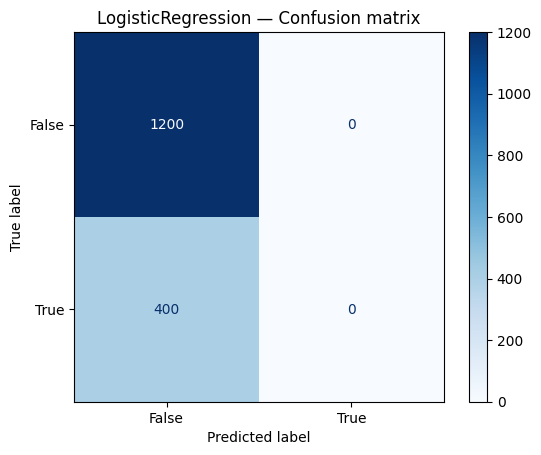


KNeighborsClassifier — Confusion matrix


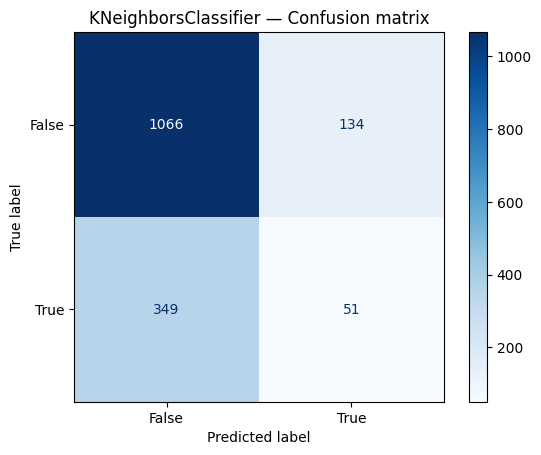


SVC — Confusion matrix


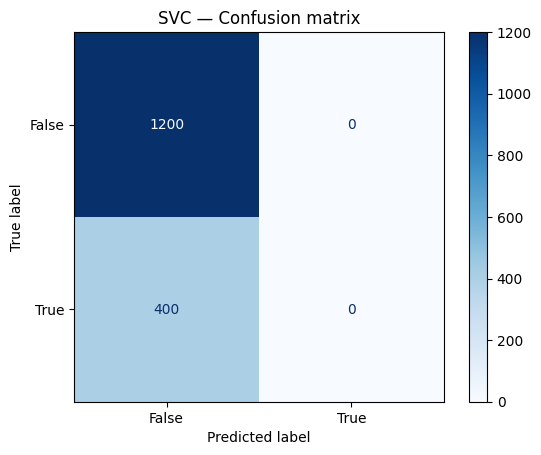


DecisionTreeClassifier — Confusion matrix


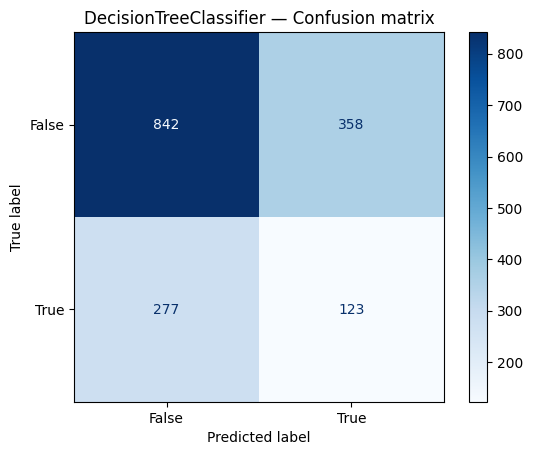


RandomForestClassifier — Confusion matrix


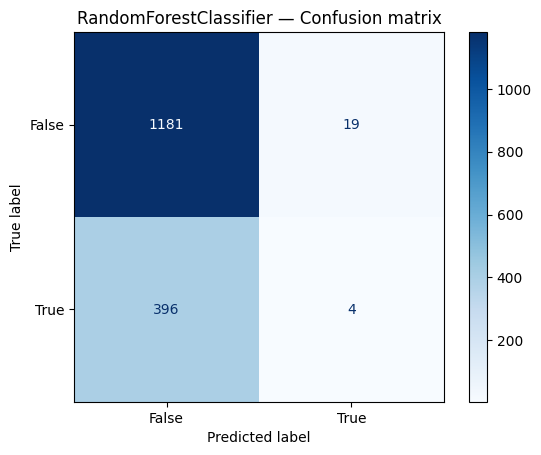


XGBClassifier — Confusion matrix


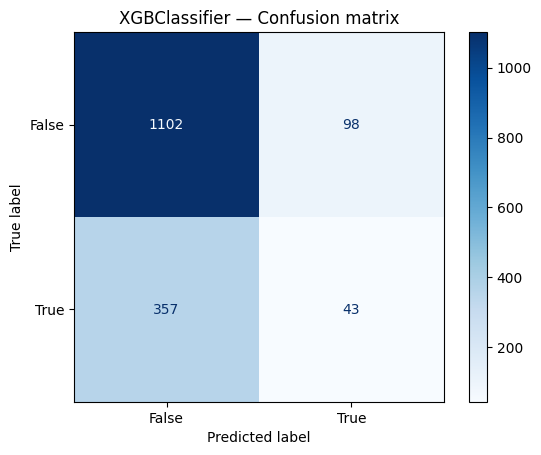

In [ ]:
results = []
preds = []

for clf in classifiers:
    for num_tr in num_transformers:
        for cat_tr in cat_transformers:
            
            preprocessor = ColumnTransformer([
                ('num', num_tr, numerical_features),
                ('cat', cat_tr, categorical_features)
            ], remainder='drop')

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', clf)
            ])
            
            start = time.time()
            pipeline.fit(X_train, y_train.squeeze())
            end = time.time()

            y_pred = pipeline.predict(X_test)
            preds.append((clf.__class__.__name__, y_pred))
             #ponoć jest metoda jak classification_raport która to liczy automatycznie i yellowbrick do wykresów
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_pred)

            results.append({
                'model' : clf.__class__.__name__,
                'num_transformer' : num_tr.__class__.__name__,
                'cat_transformer' : cat_tr.__class__.__name__,
                'accuracy' : acc,
                'precision' : precision,
                'recall' : recall,
                'f1' : f1,
                'roc_auc' : roc_auc,
                'train_time' : round(end - start, 2)
            })

pd.set_option('display.float_format', lambda x: '%.2f' % x)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='accuracy', ascending=False))

labels = np.sort(np.unique(y_test))  
for name, y_hat in preds:
    print(f"\n{name} — Confusion matrix")
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_hat, labels=labels,
        values_format='d',
        cmap='Blues',
    )
    plt.title(f'{name} — Confusion matrix')
    plt.show()